# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [137]:
type(df.iloc[0]['article_id'])

numpy.float64

In [138]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [139]:
df.shape

(45993, 3)

In [140]:
df['email'].isnull().sum()

17

In [141]:
df[df['email'].isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [142]:
df['article_id'].value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [143]:
df['article_id'].nunique() # There are 714 unique articles

714

In [144]:
# Unique users
user_article_interaction = df['email'].value_counts()
user_article_interaction

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
276d9d8ca0bf52c780b5a3fc554fa69e74f934a3    145
c60bb0a50c324dad0bffd8809d121246baef372b    145
56832a697cb6dbce14700fca18cffcced367057f    144
b2d2c70ed5de62cf8a1d4ded7dd141cfbbdd0388    142
ceef2a24a2a82031246814b73e029edba51e8ea9    140
8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e    137
e38f123afecb40272ba4c47cb25c96a9533006fa    136
53db7ac77dbb80d6f5c32ed5d19c1a8720078814    132
6c14453c049b1ef4737b08d56c480419794f91c2    131
fd824fc62b4753107e3db7704cd9e8a4a1c961f1    116
c45f9495a76bf95d2633444817f1be8205ad542d    114
12bb8a9740400ced27ae5a7d4c990ac3b7e3c77d

In [145]:
df['email'].nunique()

5148

In [146]:
user_article_interaction.max()

364

In [147]:
# number of times each user interacts with an article.
df.groupby(["email"])["article_id"].count()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
0042719415c4fca7d30bd2d4e9d17c5fc570de13     2
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     3
008ba1d5b4ebf54babf516a2d5aa43e184865da5    10
008ca24b82c41d513b3799d09ae276d37f92ce72     1
008dfc7a327b5186244caec48e0ab61610a0c660    13
009af4e0537378bf8e8caf0ad0e2994f954d822e     1
00bda305223d05f6df5d77de41abd2a0c7d895fe     4
00c2d5190e8c6b821b0e3848bf56f6e47e428994     3
00ced21f957bbcee5edf7b107b2bd05628b04774     4
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4     3
00e524e4f13137a6fac54f9c71d7769c6507ecde    11
00f8341cbecd6af00ba8c78b3bb6ec49adf83248     3
00f946b14100f0605fa25089437ee9486378872c     1
01041260c97ab9221d923b0a2c525437f148d589     2
0108ce3220657a9a89a85bdec959b0f2976dd51c     4
011455e91a24c1fb815a4deac6b6eaf5ad16819e     9
01198c5

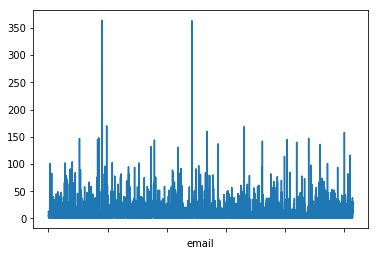

In [149]:
df.groupby(["email"])["article_id"].count().plot();

In [14]:
df.groupby(["email"])["article_id"].count().max()

364

In [15]:
# maximum number of user_article interactios
user_article_interaction.max()

364

In [16]:
# maximum number of user-article interactions
user_article_interaction.median()

3.0

In [17]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article_interaction.max() # The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [19]:
# Find and explore duplicate articles
df_content.shape

(1056, 5)

In [20]:
df_content['article_id'].isnull().sum()

0

In [21]:
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [22]:
df_content.loc[df_content['article_id'] == 50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [23]:
df_content.loc[df_content['article_id'] == 221]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221


In [24]:
df_content.loc[df_content['article_id'] == 577]

,doc_body,doc_description,doc_full_name,doc_status,article_id
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [25]:
df_content.loc[df_content['article_id'] == 232]

,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [26]:
df_content['article_id'].loc[df_content['article_id'].duplicated()]

365     50
692    221
761    398
970    577
971    232
Name: article_id, dtype: int64

In [27]:
df_content['article_id'].value_counts()

221     2
232     2
577     2
398     2
50      2
356     1
355     1
354     1
353     1
345     1
352     1
351     1
350     1
349     1
348     1
357     1
347     1
346     1
1050    1
344     1
359     1
343     1
342     1
341     1
340     1
339     1
338     1
337     1
336     1
335     1
       ..
706     1
719     1
718     1
717     1
716     1
715     1
714     1
713     1
712     1
711     1
710     1
709     1
708     1
707     1
705     1
691     1
704     1
703     1
702     1
701     1
700     1
699     1
698     1
697     1
696     1
695     1
694     1
693     1
692     1
0       1
Name: article_id, Length: 1051, dtype: int64

In [28]:
df_content.loc[df_content['article_id'] == 365]

,doc_body,doc_description,doc_full_name,doc_status,article_id
366,GO SERVERLESS WITH APEX AND COMPOSE'S MONGODB\...,While AWS's Lambda service treats each functio...,Go Serverless with Apex and Compose's MongoDB,Live,365


In [29]:
# Remove any rows that have the same article_id - only keep the first
df_content_unique = df_content.drop_duplicates(subset='article_id')

In [30]:
df_content_unique['article_id'].loc[df_content_unique['article_id'].duplicated()]

Series([], Name: article_id, dtype: int64)

In [31]:
df_content_unique.loc[df_content_unique['article_id'] == 221]

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221


In [32]:
# Remove any rows that have the same article_id - only keep the first

In [33]:
df_content.shape, df_content_unique.shape

((1056, 5), (1051, 5))

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [34]:
# a. The number of unique articles that have an interaction with a user.
df.groupby(["email"])["article_id"].count()


email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
0042719415c4fca7d30bd2d4e9d17c5fc570de13     2
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     3
008ba1d5b4ebf54babf516a2d5aa43e184865da5    10
008ca24b82c41d513b3799d09ae276d37f92ce72     1
008dfc7a327b5186244caec48e0ab61610a0c660    13
009af4e0537378bf8e8caf0ad0e2994f954d822e     1
00bda305223d05f6df5d77de41abd2a0c7d895fe     4
00c2d5190e8c6b821b0e3848bf56f6e47e428994     3
00ced21f957bbcee5edf7b107b2bd05628b04774     4
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4     3
00e524e4f13137a6fac54f9c71d7769c6507ecde    11
00f8341cbecd6af00ba8c78b3bb6ec49adf83248     3
00f946b14100f0605fa25089437ee9486378872c     1
01041260c97ab9221d923b0a2c525437f148d589     2
0108ce3220657a9a89a85bdec959b0f2976dd51c     4
011455e91a24c1fb815a4deac6b6eaf5ad16819e     9
01198c5

In [35]:
unique_articles_user_intercation_counts = df.groupby(["article_id"])["email"].nunique()

In [36]:
len(unique_articles_user_intercation_counts)

714

In [37]:
# The number of unique articles that have at least one interaction
len(unique_articles_user_intercation_counts[unique_articles_user_intercation_counts >= 1])

714

In [38]:
# The number of unique articles on the IBM platform
df_content_unique.shape

(1051, 5)

In [39]:
# The number of unique users
unique_users = df.loc[df["email"].notnull()]["email"].nunique()
unique_users

5148

In [40]:
# The number of user-article interactions
df.groupby(["article_id"])["email"].nunique().sum(), df.groupby(["email"])["article_id"].nunique().sum()


(33669, 33669)

In [41]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [42]:
user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [43]:
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())
most_viewed_article_id

'1429.0'

In [44]:
max_views = df['article_id'].value_counts().loc[1429.0]
max_views

937

In [45]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [46]:
df['user_id'].isnull().sum()

0

In [47]:
# 50% of individuals have _____ or fewer interactions
median_val = df.groupby(["user_id"])["article_id"].nunique().median()

# # The maximum number of user-article interactions by any 1 user
# max_views_by_user = df.groupby(["user_id"])["article_id"].nunique().max()

In [48]:
unique_users = 5148

In [49]:
unique_users

5148

In [50]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [51]:
user_article_interactions

45993

In [52]:
max_views_by_user

364

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [53]:
df['article_id'].value_counts().nlargest(n=10).index

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')

In [54]:
n=10
top_arcticle_ids = list(df['article_id'].value_counts().nlargest(n).index)
top_arcticle_ids

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [55]:
df.loc[1429.0]['title']

'10 tips on using jupyter notebook'

In [56]:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0']

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [57]:
list(df.loc[top_arcticle_ids]['title'].values)

['10 tips on using jupyter notebook',
 'working with notebooks in dsx',
 'times world university ranking analysis',
 'rapidly build machine learning flows with dsx',
 'jupyter notebook tutorial',
 'deep learning from scratch i: computational graphs',
 'analyze accident reports on amazon emr spark',
 'ml optimization using cognitive assistant',
 'apache spark lab, part 2: querying data',
 'putting a human face on machine learning']

In [58]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
#     top_articles_ids = get_top_article_ids(n, df)
#     top_articles = list(df.loc[top_arcticle_ids]['title'].values)
    top_articles = list(df.groupby('title')['article_id'].count().nlargest(n).index)
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df['article_id'].value_counts().nlargest(n).index)
    return top_articles # Return the top article ids

In [59]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [60]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


In [61]:
n = 10
#get article_id
top_article_ID = df['article_id'].value_counts()

#sort article_id in descending order by number of views 
top_article_ID=top_article_ID.sort_values(ascending=False)

#use index to pull #n numbers of output else you will get all instead of n
top_articles=top_article_ID.head(n).index

In [62]:
top_articles

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')

In [63]:
#get the articles
article_counts = df.groupby('title')['article_id'].count() 

#sort the articles
article_counts = article_counts.sort_values(ascending=False)

#create list
top_articles= list(article_counts.head(n).index)
top_articles

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [64]:
article_counts = df.groupby('title')['article_id'].count()
article_counts

title
0 to life-changing app: new apache systemml api on spark shell                             35
0 to life-changing app: scala first steps and an interview with jakob odersky              26
10 data science podcasts you need to be listening to right now                             41
10 data science, machine learning and ai podcasts you must listen to                       25
10 essential algorithms for machine learning engineers                                     95
10 must attend data science, ml and ai conferences in 2018                                 91
10 pieces of advice to beginner data scientists                                             4
10 powerful features on watson data platform, no coding necessary                          37
10 tips on using jupyter notebook                                                          32
1357    what i learned implementing a classifier from ...\nName: title, dtype: object     108
1448    i ranked every intro to data science course on

In [65]:
article_counts.loc['0 to life-changing app: new apache systemml api on spark shell']

35

In [66]:
df.loc[1429.0, :]

article_id                                  528
title         10 tips on using jupyter notebook
user_id                                     103
Name: 1429, dtype: object

In [67]:
df['article_id'].value_counts().nlargest(n)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [68]:
df['article_id']

0        1430.0
1        1314.0
2        1429.0
3        1338.0
4        1276.0
5        1432.0
6        1429.0
7         593.0
8        1314.0
9        1185.0
10        993.0
11         14.0
12       1395.0
13       1314.0
14       1170.0
15        542.0
16         12.0
17       1430.0
18       1338.0
19        173.0
20       1314.0
21       1338.0
22       1320.0
23       1052.0
24       1432.0
25       1393.0
26       1338.0
27        593.0
28        362.0
29       1364.0
          ...  
45963    1360.0
45964     291.0
45965    1430.0
45966    1400.0
45967     495.0
45968     202.0
45969    1400.0
45970     485.0
45971    1400.0
45972     588.0
45973    1398.0
45974     270.0
45975    1165.0
45976      20.0
45977    1305.0
45978     962.0
45979     962.0
45980     138.0
45981    1324.0
45982    1324.0
45983    1157.0
45984    1416.0
45985    1394.0
45986    1125.0
45987    1282.0
45988    1324.0
45989     142.0
45990     233.0
45991    1160.0
45992      16.0
Name: article_id, Length

In [69]:
list(df.groupby('title')['article_id'].count().nlargest(n).index)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [70]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [71]:
df[['article_id', 'user_id']].head()

,article_id,user_id
0,1430.0,1
1,1314.0,2
2,1429.0,3
3,1338.0,4
4,1276.0,5


In [72]:
pd.get_dummies(df[['article_id', 'user_id']], columns=['article_id']).head()

,user_id,article_id_0.0,article_id_2.0,article_id_4.0,article_id_8.0,article_id_9.0,article_id_12.0,article_id_14.0,article_id_15.0,article_id_16.0,...,article_id_1434.0,article_id_1435.0,article_id_1436.0,article_id_1437.0,article_id_1439.0,article_id_1440.0,article_id_1441.0,article_id_1442.0,article_id_1443.0,article_id_1444.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id']).count().notnull().unstack()
    user_item.fillna(0, inplace=True)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [74]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [75]:
x = np.array(user_item.loc[1])
y = np.array(user_item.loc[2])
np.dot(x, y)

2

In [76]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarity = []
    for id in range(1, user_item.shape[0] + 1):
        if id != user_id:
            x = np.array(user_item.loc[user_id])
            y = np.array(user_item.loc[id])
            similarity = np.dot(x, y)
            user_similarity.append((id, similarity))
            
    # sort by similarity
    sorted(user_similarity, key=lambda x:(-x[1],x[0]))
    # create list of just the ids
    most_similar_users = []
    for pair in user_similarity:
        most_similar_users.append(pair[0])
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [77]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
The 5 most similar users to user 3933 are: [1, 2, 3, 4, 5]
The 3 most similar users to user 46 are: [1, 2, 3]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [78]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [79]:
df.loc[df['article_id'] == 1430.0, 'title'][0]

'using pixiedust for fast, flexible, and easier data analysis and experimentation'

In [80]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_id=df.article_id.isin(article_ids)
    
    article_names=(df[article_id]).title.drop_duplicates().tolist()
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Extracting article_ids
    mask = user_item.loc[user_id] == 1
    article_ids_tuples = user_item.loc[user_id][mask]

    article_ids_num = [article_ids_tuple[1] for article_ids_tuple in article_ids_tuples.index.tolist()]
    article_names = get_article_names(article_ids_num)
    article_ids = [str(article_id) for article_id in article_ids_num]
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    user_articles, _ = get_user_articles(user_id)
    user_articles = set(user_articles)
    recs = []
    for similar_user in similar_users:
        similar_user_articles_ids, _ = get_user_articles(similar_user)
        for similar_user_articles_id in similar_user_articles_ids:
            if similar_user_articles_id not in user_articles:
                recs.append(similar_user_articles_id)

        if len(recs) > m:
            recs = recs[:m]
            break

    return recs # return your recommendations for this user_id    

In [81]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1


['healthcare python streaming application demo',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'use r dataframes & ibm watson natural language understanding',
 'experience iot with coursera',
 'working interactively with rstudio and notebooks in dsx',
 'build a python app on the streaming analytics service',
 'practical tutorial on random forest and parameter tuning in r',
 'using deep learning to reconstruct high-resolution audio',
 'data visualization: the importance of excluding unnecessary details']

In [82]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [133]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    num_interactions = df.user_id.value_counts()
    num_interactions = num_interactions.to_frame('num_interactions')
    num_interactions=num_interactions.rename(columns={'user_id':'neighbor_id'})
    
    similar_users = find_similar_users(user_id)
    similarity = []

    x = np.array(user_item.loc[user_id])
    for similar_user_id in similar_users:
        y = np.array(user_item.loc[similar_user_id])
        similarity.append(np.dot(x, y))
    
    neighbors_df = pd.DataFrame({'neighbor_id':similar_users, 'similarity': similarity})
    neighbors_df=neighbors_df.merge(num_interactions, left_on='neighbor_id',right_index=True)
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False], inplace=True)
    neighbors_df.reset_index(drop=True, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = [] 
    count = df['article_id'].value_counts() 
    count.index = count.index.astype(str)   # set count index to str
    neighbors_df = get_top_sorted_users(user_id) 
    user_articles = get_user_articles(user_id)[0] 
    
    for neighbor_user in neighbors_df['neighbor_id']:
        neighbor_user_articles = get_user_articles(neighbor_user)[0]       
        recs_to_add = list(np.setdiff1d(neighbor_user_articles, user_articles)) 
        ids = list(count[recs_to_add].sort_values(ascending=False).index) 
        
        for id in ids:
            if id not in recs and len(recs) < m:
                recs.append(id)
            if len(recs) >= m:
                break;
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [134]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [89]:
user1_neighbors_df = get_top_sorted_users(1)
user131_neighbors_df = get_top_sorted_users(131)

In [90]:
user1_neighbors_df.head()

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [91]:
user131_neighbors_df.head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,98,29,170
6,3764,29,169
7,49,29,147
8,3697,29,145
9,242,25,148


In [92]:
### Tests with a dictionary of results

user1_most_sim = user1_neighbors_df.iloc[0][0]# Find the user that is most similar to user 1 
user131_10th_sim = user131_neighbors_df.iloc[9][0]# Find the 10th most similar user to user 131

In [93]:
type(user1_most_sim), user131_10th_sim

(numpy.int64, 242)

In [94]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [95]:
sol_5_dict

{'The user that is most similar to user 1.': 3933,
 'The user that is the 10th most similar to user 131': 242}

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Explanation: Since we lack any information about the new user, the collaborative filtering approach will not be applicable. Therefore, the only option available for the new user is to utilize the rank-based approach. In particular, we can use `get_top_articles` or `get_top_article_ids` in these situation.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [96]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_article_ids = get_top_article_ids(10)# Your recommendations here
new_user_recs = [str(article_id) for article_id in top_article_ids]


In [97]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [98]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [99]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [100]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [101]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [102]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**
As indicated in the cell below, since the data does not have any nan value, svd works in our case.

In [103]:
user_item_matrix.isna().sum().sum(), u.shape, s.shape, vt.shape

(0, (5149, 5149), (714,), (714, 714))

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

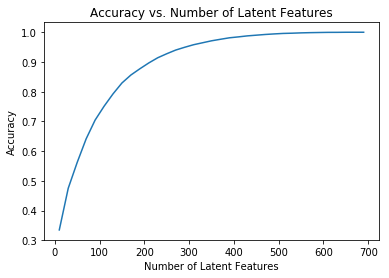

In [104]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [105]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    columns_info = list(user_item_test.columns.values)
    test_arts = [column_info[1] for column_info in columns_info]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [106]:
# 'How many users can we make predictions for in the test set?'
train_idx = list(user_item_train.index)
num_predictions_users = len(set(test_idx).intersection(train_idx))
num_predictions_users

20

In [108]:
# 'How many users in the test set are we not able to make predictions for because of the cold start problem?'
num_non_predictions_users = user_item_test.shape[0] - num_predictions_users
num_non_predictions_users

662

In [109]:
# 'How many articles can we make predictions for in the test set?'
columns_info = list(user_item_train.columns.values)
train_arts = [column_info[1] for column_info in columns_info]
num_predictions_arts = len(set(test_arts).intersection(train_arts))
num_predictions_arts

574

In [110]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [111]:
# fit SVD on the user_item_train matrix
user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack()
user_item_train = user_item_train.fillna(0).astype(int)
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [112]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [118]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
test_users_ids=list(set(test_idx).intersection(train_idx))
test_arts_ids=list(set(test_arts).intersection(train_arts))
len(test_users_ids), len(test_arts_ids)

(20, 574)

In [148]:
train_idx = user_item_train.index
train_arts = user_item_train.columns

pandas.core.indexes.numeric.Int64Index

In [160]:
test_users_ids=train_idx.isin(test_idx)
test_users_ids

(4487,)

In [151]:
test_arts_ids=train_arts.isin(test_arts)
test_arts_ids.shape

(714,)

In [153]:
u_test = u_train[test_users_ids, :]
vt_test = vt_train[:,test_arts_ids]
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [163]:
test_user_intersect = np.in1d(test_idx, train_idx)
test_articles_intersect = np.in1d(test_arts, train_arts)
test_user_intersect.shape, test_articles_intersect.shape

((682,), (574,))

In [164]:
user_item_test = user_item_test.loc[test_user_intersect,test_articles_intersect]

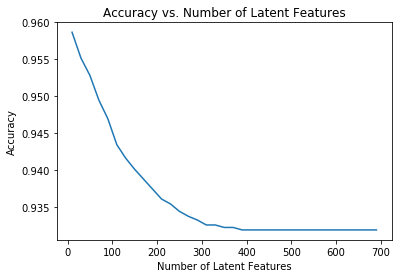

In [165]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_new_test, u_new_test, vt_new_test = s_new_train, u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_test_est = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_test_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
To begin with, the number of test users we utilize to evaluate our recommendation system is too limited to accurately assess its performance. However, based on the test accuracy, it appears that increasing the number of latent features does not necessarily enhance the recommendation system's performance. 

One way to evaluate the performance of the matrix factorization model is to conduct an A/B test. In this test, users are divided into two equal-sized groups: the control group and the experimental group. If we observe a statistically significant increase in user interaction with the articles in the experimental group compared to the control group, we can confidently replace the current model with the matrix factorization model.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [150]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0